---

# Lib


In [1]:
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

from xgboost import XGBClassifier
import optuna

---

# Read file


In [3]:
df_train = pd.read_csv("../data/processed/train.csv", encoding="utf-8")
df_1 = pd.read_csv("../data/processed/val.csv", encoding="utf-8")
df_2 = pd.read_csv("../data/processed/test.csv", encoding="utf-8")
df_val = pd.concat([df_1, df_2], axis=0)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3592 entries, 0 to 3591
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  3592 non-null   object
 1   label    3592 non-null   object
dtypes: object(2)
memory usage: 56.2+ KB


In [5]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1540 entries, 0 to 769
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  1540 non-null   object
 1   label    1540 non-null   object
dtypes: object(2)
memory usage: 36.1+ KB


---

# Labels


## Train


In [6]:
matrix_labels_train = df_train["label"]

In [7]:
matrix_labels_train.head()

0    negative
1    positive
2     neutral
3    positive
4    negative
Name: label, dtype: object

In [8]:
print(f"Number of labels: {len(matrix_labels_train.unique())}")
print(f"Labels: {matrix_labels_train.unique()}")

Number of labels: 3
Labels: ['negative' 'positive' 'neutral']


## Val


In [9]:
matrix_labels_val = df_val["label"]

In [10]:
matrix_labels_val.head()

0    positive
1    positive
2    positive
3    negative
4    positive
Name: label, dtype: object

In [11]:
print(f"Number of labels: {len(matrix_labels_val.unique())}")
print(f"Labels: {matrix_labels_val.unique()}")

Number of labels: 3
Labels: ['positive' 'negative' 'neutral']


---

# Train, val split


In [12]:
# Train
X_train = df_train[["comment"]]
y_train = matrix_labels_train

# Validation
X_val = df_val[["comment"]]
y_val = matrix_labels_val

In [13]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train).astype(np.int64)
print(f"Labels: {le.classes_}")

Labels: ['negative' 'neutral' 'positive']


---

# Vectorize


In [14]:
vec = TfidfVectorizer(
    analyzer="char",
    min_df=2,
    max_df=0.95,
    ngram_range=(3, 5),
    max_features=30000,
)

In [15]:
# Fit TF-IDF on training and transform train/test
X_train_vec = vec.fit_transform(X_train["comment"])
X_val_vec = vec.transform(X_val["comment"])

In [16]:
print(f"Train shape: {X_train_vec.shape}")
print(f"Test shape: {X_val_vec.shape}")
print(f"Vocabulary size: {len(vec.get_feature_names_out())}")

Train shape: (3592, 30000)
Test shape: (1540, 30000)
Vocabulary size: 30000


---

# Load Model


---

## Xgboost


### Model


In [66]:
def objective(trial):

    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "random_state": 42,
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0),
    }

    skf = cv_splitter
    f1_scores = []

    for train_idx, val_idx in skf.split(X_train_vec, y_train):
        X_tr, X_val = X_train_vec[train_idx], X_train_vec[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = XGBClassifier(**params)
        model.fit(X_tr, y_tr)

        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average="macro")
        f1_scores.append(f1)

    return np.mean(f1_scores)

In [103]:
study = optuna.create_study(direction="maximize", study_name="xgb_f1_macro")
study.optimize(objective, n_trials=20)

[I 2025-12-20 13:28:56,292] A new study created in memory with name: xgb_f1_macro
[I 2025-12-20 13:30:39,572] Trial 0 finished with value: 0.44711505342331714 and parameters: {'max_depth': 3, 'learning_rate': 0.04063674798433194, 'n_estimators': 309, 'subsample': 0.641823779381439, 'colsample_bytree': 0.8200463980140058, 'gamma': 2.807290046137219, 'reg_alpha': 0.36802018685071575, 'reg_lambda': 0.866724987602659}. Best is trial 0 with value: 0.44711505342331714.
[I 2025-12-20 13:35:00,986] Trial 1 finished with value: 0.45830390536127635 and parameters: {'max_depth': 6, 'learning_rate': 0.032537891247789504, 'n_estimators': 451, 'subsample': 0.995022077357469, 'colsample_bytree': 0.8615937110424611, 'gamma': 1.303114459170851, 'reg_alpha': 0.3671342562260991, 'reg_lambda': 0.6035285406375067}. Best is trial 1 with value: 0.45830390536127635.
[I 2025-12-20 13:38:12,045] Trial 2 finished with value: 0.4857946661590106 and parameters: {'max_depth': 6, 'learning_rate': 0.10753354179711426

In [104]:
print("Best f1-macro:", study.best_value)
print("Best trial:", study.best_trial.number)

Best f1-macro: 0.48725435270910095
Best trial: 14


In [105]:
best_params = study.best_params

print("Best params:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

Best params:
  max_depth: 5
  learning_rate: 0.07590214057473325
  n_estimators: 697
  subsample: 0.7058329982069236
  colsample_bytree: 0.9920929369117178
  gamma: 0.0675097620876346
  reg_alpha: 0.7681049077910618
  reg_lambda: 0.02181451468909168


In [106]:
# Build final model with best hyperparameters
best_params.update(
    {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "random_state": 42,
    }
)

xgb_model = XGBClassifier(**best_params)

In [107]:
xgb_model.fit(X_train_vec, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9920929369117178
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


### Eval


In [165]:
y_pred = xgb_model.predict(X_val_vec)
y_pred = le.inverse_transform(y_pred)

In [166]:
print(f"accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"precision: {precision_score(y_val, y_pred, average='macro', zero_division=0):.4f}")
print(f"recall: {recall_score(y_val, y_pred, average='macro', zero_division=0):.4f}")
print(f"f1: {f1_score(y_val, y_pred, average='macro', zero_division=0):.4f}")

accuracy: 0.6623
precision: 0.5345
recall: 0.5027
f1: 0.4972


In [167]:
# Classified report
print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=0))

              precision    recall  f1-score   support

    negative       0.66      0.66      0.66       607
     neutral       0.26      0.06      0.10       156
    positive       0.68      0.79      0.73       777

    accuracy                           0.66      1540
   macro avg       0.53      0.50      0.50      1540
weighted avg       0.63      0.66      0.64      1540



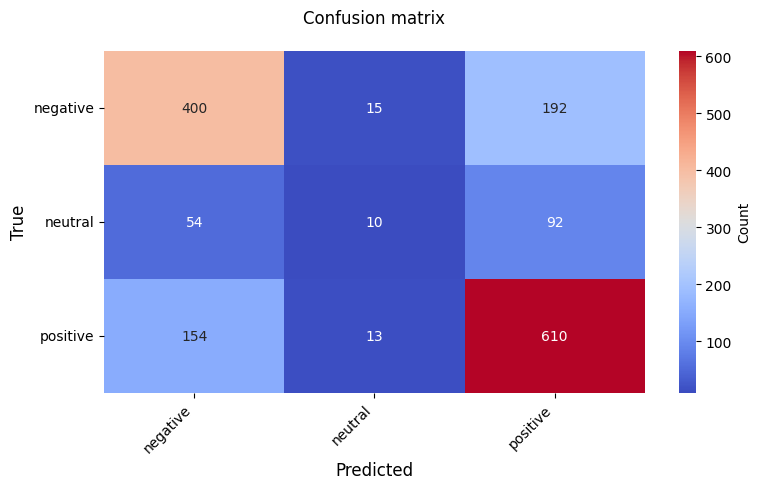

In [168]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={"label": "Count"},
)
plt.title("Confusion matrix", pad=20)
plt.ylabel("True", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Test


In [169]:
df_test = pd.read_csv("../data/processed/test.csv")
df_test_predict = df_test.copy()
df_test_predict.head()

,brand,model,version,year,segment,comment,label
0,mitsubishi,attrage,cvt,2025,sedan,ngoại thất hiện_đại hẳn,positive
1,nissan,almera,NaN,2025,sedan,thương_hiệu ninsan chỗ chê gtr nổi_tiếng khấp ...,positive
2,mg,5,luxury,2025,sedan,xe trung_quốc thiết_kế đẹp,positive
3,hyundai,creta,n line,2025,suv,giá trưng_bày,negative
4,toyota,vios,NaN,2025,sedan,vụ tai_nạn mấy hôm trung_quốc vios sởn gai_ốc ...,negative


In [170]:
# Try prediction
samples = df_test["comment"].tolist()
samples_vec = vec.transform(samples)
preds = grid_svm.best_estimator_.predict(samples_vec)
preds = le.inverse_transform(preds)

for i, (text, pred) in enumerate(zip(samples, preds), start=1):
    df_test_predict.loc[i - 1, "predicted_label"] = pred

In [171]:
df_test_predict[["label", "predicted_label"]].groupby(
    ["label", "predicted_label"]
).value_counts()

label     predicted_label
negative  negative           197
          neutral             19
          positive            88
neutral   negative            31
          neutral             10
          positive            37
positive  negative            81
          neutral             11
          positive           296
Name: count, dtype: int64

---

# Save model


In [172]:
model_save_path = "../models/ml/"

# Save SVM model
joblib.dump(grid_svm.best_estimator_, model_save_path + "svm.pkl")
print(f"SVM model saved to {model_save_path}svm_model.pkl")

# Save Logistic Regression model
joblib.dump(grid_log.best_estimator_, model_save_path + "logistic.pkl")
print(f"Logistic Regression model saved to {model_save_path}logistic_regression.pkl")

# Save XGBoost model
joblib.dump(xgb_model, model_save_path + "xgboost_model.pkl")
print(f"XGBoost model saved to {model_save_path}xgboost_model.pkl")

SVM model saved to ../models/ml/svm_model.pkl
Logistic Regression model saved to ../models/ml/logistic_regression.pkl
XGBoost model saved to ../models/ml/xgboost_model.pkl
